In [5]:
def calEnt(dataSet):
    n = dataSet.shape[0] #数据集总行数
    iset = dataSet.iloc[:,-1].value_counts() #标签的所有类别
    p = iset/n #每一类标签所占比
    ent = (-p*np.log2(p)).sum() #计算信息熵
    return ent

In [2]:
#创建数据集
import numpy as np
import pandas as pd

def createDataSet():
    row_data = {'no surfacing':[1,1,1,0,0],
                'flippers':[1,1,0,1,1],
                'fish':['yes','yes','no','no','no']}
    dataSet = pd.DataFrame(row_data)
    return dataSet

In [3]:
dataSet = createDataSet()
dataSet

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [6]:
print(calEnt(dataSet))

0.9709505944546686


In [7]:
a=(3/5)*(-(2/3)*np.log2(2/3)-(1/3)*np.log2(1/3))
calEnt(dataSet)-a

0.4199730940219749

In [8]:
#选择最优的列进行切分
def bestSplit(dataSet):
    baseEnt = calEnt(dataSet) #计算原始熵
    bestGain = 0 #初始化信息增益
    axis = -1 #初始化最佳切分列，标签列
    for i in range(dataSet.shape[1]-1): #对特征的每一列进行循环
        levels= dataSet.iloc[:,i].value_counts().index #提取出当前列的所有取值
        ents = 0 #初始化子节点的信息熵
        for j in levels: #对当前列的每一个取值进行循环
            childSet = dataSet[dataSet.iloc[:,i]==j] #某一个子节点的dataframe
            ent = calEnt(childSet) #计算某一个子节点的信息熵
            ents += (childSet.shape[0]/dataSet.shape[0])*ent #计算当前列的信息熵
            #print(f'第{i}列的信息熵为{ents}')
        infoGain = baseEnt-ents #计算当前列的信息增益
        #print(f'第{i}列的信息增益为{infoGain}')
        if (infoGain > bestGain):
            bestGain = infoGain #选择最大信息增益
            axis = i #最大信息增益所在列的索引
    return axis

In [9]:
bestSplit(dataSet)

0

In [10]:
def mySplit(dataSet,axis,value):
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col]==value,:].drop(col,axis=1)
    return redataSet

In [11]:
value =1
axis=0
mySplit(dataSet,axis,value)

,flippers,fish
0,1,yes
1,1,yes
2,0,no


In [12]:
col = dataSet.columns[axis]

col

'no surfacing'

In [12]:
dataSet.loc[dataSet[col]==value,:].drop(col,axis=1)

,flippers,fish
0,1,yes
1,1,yes
2,0,no


In [14]:
def createTree(dataSet):
    featlist = list(dataSet.columns) #提取出数据集所有的列
    classlist = dataSet.iloc[:,-1].value_counts() #获取最后一列类标签
    #判断最多标签数目是否等于数据集行数，或者数据集是否只有一列
    if classlist[0]==dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0] #如果是，返回类标签
    axis = bestSplit(dataSet) #确定出当前最佳切分列的索引
    bestfeat = featlist[axis] #获取该索引对应的特征
    myTree = {bestfeat:{}} #采用字典嵌套的方式存储树信息
    del featlist[axis] #删除当前特征
    valuelist = set(dataSet.iloc[:,axis]) #提取最佳切分列所有属性值
    for value in valuelist: #对每一个属性值递归建树
        myTree[bestfeat][value] = createTree(mySplit(dataSet,axis,value))
    return myTree

In [15]:
myTree = createTree(dataSet)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [15]:
#树的存储
np.save('myTree.npy',myTree)

In [16]:
#树的读取
read_myTree = np.load('myTree.npy').item()
read_myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [17]:
def classify(inputTree,labels, testVec):
    firstStr = next(iter(inputTree)) #获取决策树第一个节点
    secondDict = inputTree[firstStr] #下一个字典
    featIndex = labels.index(firstStr) #第一个节点所在列的索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict :
                classLabel = classify(secondDict[key], labels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [18]:
labels = list(dataSet.columns)

In [19]:
labels

['no surfacing', 'flippers', 'fish']

In [20]:
inputTree = myTree

In [21]:
inputTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [22]:
firstStr = next(iter(inputTree))
firstStr

'no surfacing'

In [23]:
secondDict = inputTree[firstStr]
secondDict

{0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}

In [24]:
def acc_classify(train,test):
    inputTree = createTree(train) #根据测试集生成一棵树
    labels = list(train.columns) #数据集所有的列名称
    result = []
    for i in range(test.shape[0]): #对测试集中每一条数据进行循环
        testVec = test.iloc[i,:-1] #测试集中的一个实例
        classLabel = classify(inputTree,labels,testVec) #预测该实例的分类
        result.append(classLabel) #将分类结果追加到result列表中
    test['predict']=result #将预测结果追加到测试集最后一列
    acc = (test.iloc[:,-1]==test.iloc[:,-2]).mean() #计算准确率
    print(f'模型预测准确率为{acc}')
    return test

In [25]:
train = dataSet
test = dataSet.iloc[:3,:]

In [26]:
train

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [27]:
test

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no


In [28]:
acc_classify(train,test)

模型预测准确率为1.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,no surfacing,flippers,fish,predict
0,1,1,yes,yes
1,1,1,yes,yes
2,1,0,no,no


In [29]:
#导入相应的包
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

In [30]:
#特征
Xtrain = dataSet.iloc[:,:-1]

In [31]:
Xtrain

,no surfacing,flippers
0,1,1
1,1,1
2,1,0
3,0,1
4,0,1


In [32]:
#标签
Ytrain = dataSet.iloc[:,-1]
labels = Ytrain.unique().tolist()
Ytrain = Ytrain.apply(lambda x: labels.index(x)) #将本文转换为数字

In [33]:
Ytrain

0    0
1    0
2    1
3    1
4    1
Name: fish, dtype: int64

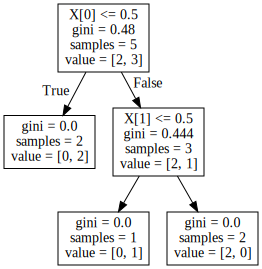

In [35]:
#绘制树模型
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(dot_data)

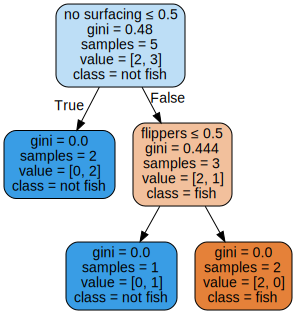

In [36]:
#给图形增加标签和颜色
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=['no surfacing', 'flippers'],
                                class_names=['fish', 'not fish'],
                                filled=True, rounded=True,
                                special_characters=True)
graphviz.Source(dot_data)

In [37]:
#利用render方法生成图形
graph = graphviz.Source(dot_data)
graph.render("fish")

'fish.pdf'

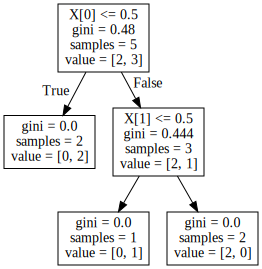

In [38]:
#绘制树模型
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(dot_data)

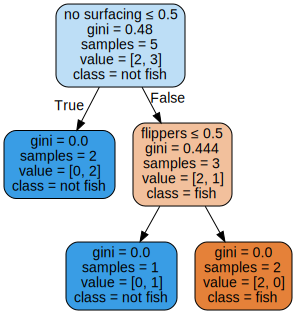

In [39]:
#给图形增加标签和颜色
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=['no surfacing', 'flippers'],
                                class_names=['fish', 'not fish'],
                                filled=True, rounded=True,
                                special_characters=True)
graphviz.Source(dot_data)

In [40]:
#利用render方法生成图形
graph = graphviz.Source(dot_data)
graph.render("fish")

'fish.pdf'

In [41]:
def getNumLeafs(myTree):
    numLeafs = 0 #初始化叶节点数目
    firstStr = next(iter(myTree)) #获得树的第一个键值，即第一个特征
    secondDict = myTree[firstStr] #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]) == dict: #测试该节点是否为字典
            numLeafs += getNumLeafs(secondDict[key]) #是字典，递归，循环计算新分支叶节点数
        else:
            numLeafs +=1 #不是字典，代表此结点为叶子结点
    return numLeafs

In [42]:
firstStr = next(iter(myTree))

In [43]:
firstStr

'no surfacing'

In [44]:
getNumLeafs(myTree)

3

In [45]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            thisDepth = 1+getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth>maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [46]:
getTreeDepth(myTree)

2

In [47]:
"""
函数功能:绘制节点
参数说明:
nodeTxt：节点名
centerPt：文本位置
parentPt：标注的箭头位置
nodeType：节点格式
"""
def plotNode(nodeTxt, cntrPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-") #定义箭头格式
    createPlot.ax1.annotate(nodeTxt,
                            xy=parentPt,xycoords='axes fraction',
                            xytext=cntrPt, textcoords='axes fraction',
                            va="center", ha="center",
                            bbox=nodeType,
                            arrowprops=arrow_args)

In [48]:
"""
函数功能:标注有向边属性值
参数说明:
cntrPt、parentPt：用于计算标注位置
txtString：标注的内容
"""
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0] #计算标注位置的横坐标
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1] #计算标注位置的纵坐标
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=0)

In [49]:
"""
函数功能:绘制决策树
参数说明:
    myTree：决策树(字典)
    parentPt：标注的内容
    nodeTxt：节点名
"""
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8") #设置中间节点格式
    leafNode = dict(boxstyle="round4", fc="0.8") #设置叶节点格式
    numLeafs = getNumLeafs(myTree) #获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree) #获取决策树层数
    firstStr = next(iter(myTree)) #下个字典
    cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)#确定中心位置
    plotMidText(cntrPt, parentPt, nodeTxt) #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode) #绘制节点
    secondDict = myTree[firstStr] #下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #y偏移
    for key in secondDict.keys():
        if type(secondDict[key])== dict: #测试该结点是否为字典
            plotTree(secondDict[key],cntrPt,str(key)) #是字典则不是叶结点，递归调用继续绘制
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW #x偏移
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [50]:
"""
函数功能:创建绘制面板
参数说明:
inTree：决策树(字典)
"""
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white') #创建fig
    fig.clf() #清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops) #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree)) #获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree)) #获取决策树深度
    plotTree.xOff = -0.5/plotTree.totalW #x偏移的初始值
    plotTree.yOff = 1.0 #y偏移的初始值
    plotTree(inTree, (0.5,1.0), '') #绘制决策树
    plt.show() #显示绘制结果

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文

In [52]:
lenses = pd.read_table('lenses.txt',header = None)
lenses.columns =['age','prescript','astigmatic','tearRate','class']
lenses

,age,prescript,astigmatic,tearRate,class
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses
5,young,hyper,no,normal,soft
6,young,hyper,yes,reduced,no lenses
7,young,hyper,yes,normal,hard
8,pre,myope,no,reduced,no lenses
9,pre,myope,no,normal,soft


In [53]:
import random

In [54]:
"""
函数功能：切分训练集和测试集
参数说明：
    dataSet:输入的数据集
    rate：训练集所占比例
返回：
    train,test:切分好的训练集和测试集
"""
def randSplit(dataSet, rate):
    l = list(dataSet.index) #提取出索引
    random.shuffle(l) #随机打乱索引
    dataSet.index = l #将打乱后的索引重新赋值给原数据集
    n = dataSet.shape[0] #总行数
    m = int(n * rate) #训练集的数量
    train = dataSet.loc[range(m), :] #提取前m个记录作为训练集
    test = dataSet.loc[range(m, n), :] #剩下的作为测试集
    dataSet.index = range(dataSet.shape[0]) #更新原数据集的索引
    test.index = range(test.shape[0]) #更新测试集的索引
    return train, test

In [55]:
dataSet = lenses

In [56]:
l = list(dataSet.index)
l

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [57]:
random.shuffle(l)

In [58]:
l

[15,
 7,
 17,
 19,
 16,
 9,
 2,
 11,
 12,
 20,
 14,
 21,
 4,
 6,
 3,
 10,
 8,
 22,
 0,
 23,
 13,
 1,
 5,
 18]

In [59]:
dataSet.index = l

In [60]:
dataSet

,age,prescript,astigmatic,tearRate,class
15,young,myope,no,reduced,no lenses
7,young,myope,no,normal,soft
17,young,myope,yes,reduced,no lenses
19,young,myope,yes,normal,hard
16,young,hyper,no,reduced,no lenses
9,young,hyper,no,normal,soft
2,young,hyper,yes,reduced,no lenses
11,young,hyper,yes,normal,hard
12,pre,myope,no,reduced,no lenses
20,pre,myope,no,normal,soft


In [61]:
rate =0.8
n = dataSet.shape[0] #总行数
m = int(n * rate) #训练集的数量

In [62]:
n

24

In [63]:
m

19

In [64]:
train = dataSet.loc[range(m), :] 

In [65]:
train

,age,prescript,astigmatic,tearRate,class
0,presbyopic,myope,yes,reduced,no lenses
1,presbyopic,hyper,no,normal,soft
2,young,hyper,yes,reduced,no lenses
3,pre,hyper,yes,reduced,no lenses
4,pre,hyper,no,reduced,no lenses
5,presbyopic,hyper,yes,reduced,no lenses
6,pre,hyper,no,normal,soft
7,young,myope,no,normal,soft
8,presbyopic,myope,no,reduced,no lenses
9,young,hyper,no,normal,soft


In [66]:
test = dataSet.loc[range(m, n), :] #剩下的作为测试集

In [67]:
test

,age,prescript,astigmatic,tearRate,class
19,young,myope,yes,normal,hard
20,pre,myope,no,normal,soft
21,pre,myope,yes,normal,hard
22,presbyopic,myope,no,normal,no lenses
23,presbyopic,myope,yes,normal,hard


In [68]:
test.index = range(test.shape[0]) #更新测试集的索引

In [69]:
test

,age,prescript,astigmatic,tearRate,class
0,young,myope,yes,normal,hard
1,pre,myope,no,normal,soft
2,pre,myope,yes,normal,hard
3,presbyopic,myope,no,normal,no lenses
4,presbyopic,myope,yes,normal,hard


In [70]:
train1,test1 = randSplit(lenses, 0.8)

In [71]:
train1

,age,prescript,astigmatic,tearRate,class
0,presbyopic,hyper,yes,reduced,no lenses
1,presbyopic,hyper,no,reduced,no lenses
2,pre,hyper,no,reduced,no lenses
3,young,hyper,yes,reduced,no lenses
4,young,myope,yes,normal,hard
5,pre,hyper,yes,normal,no lenses
6,pre,hyper,yes,reduced,no lenses
7,young,myope,no,normal,soft
8,pre,hyper,no,normal,soft
9,pre,myope,no,normal,soft


In [72]:
test1

,age,prescript,astigmatic,tearRate,class
0,presbyopic,myope,yes,normal,hard
1,pre,myope,yes,normal,hard
2,young,myope,no,reduced,no lenses
3,presbyopic,hyper,no,normal,soft
4,young,hyper,no,normal,soft


In [73]:
#利用训练集生成决策树
lensesTree = createTree(train1)
lensesTree

{'tearRate': {'normal': {'age': {'pre': {'astigmatic': {'no': 'soft',
      'yes': 'no lenses'}},
    'young': {'astigmatic': {'no': 'soft', 'yes': 'hard'}},
    'presbyopic': 'no lenses'}},
  'reduced': 'no lenses'}}

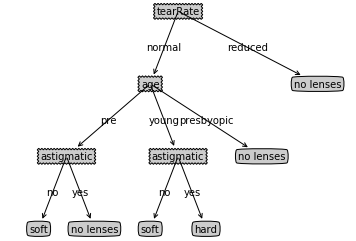

In [74]:
#构造注解树
createPlot(lensesTree)

In [75]:
#用决策树进行分类并计算有预测准确率
acc_classify(train1,test1)

模型预测准确率为0.4


,age,prescript,astigmatic,tearRate,class,predict
0,presbyopic,myope,yes,normal,hard,no lenses
1,pre,myope,yes,normal,hard,no lenses
2,young,myope,no,reduced,no lenses,no lenses
3,presbyopic,hyper,no,normal,soft,no lenses
4,young,hyper,no,normal,soft,soft


In [76]:
Xtrain1 = train1.iloc[:,:-1]
Xtrain1

,age,prescript,astigmatic,tearRate
0,presbyopic,hyper,yes,reduced
1,presbyopic,hyper,no,reduced
2,pre,hyper,no,reduced
3,young,hyper,yes,reduced
4,young,myope,yes,normal
5,pre,hyper,yes,normal
6,pre,hyper,yes,reduced
7,young,myope,no,normal
8,pre,hyper,no,normal
9,pre,myope,no,normal


In [77]:
Xtrain1['age'].value_counts()

pre           7
presbyopic    6
young         6
Name: age, dtype: int64

In [78]:
labels = Xtrain1['age'].unique().tolist()
labels

['presbyopic', 'pre', 'young']

In [79]:
Xtrain1['age']= Xtrain1['age'].apply(lambda x: labels.index(x))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
Xtrain1

,age,prescript,astigmatic,tearRate
0,0,hyper,yes,reduced
1,0,hyper,no,reduced
2,1,hyper,no,reduced
3,2,hyper,yes,reduced
4,2,myope,yes,normal
5,1,hyper,yes,normal
6,1,hyper,yes,reduced
7,2,myope,no,normal
8,1,hyper,no,normal
9,1,myope,no,normal


In [81]:
for i in Xtrain1.columns:
    labels = Xtrain1[i].unique().tolist()
    Xtrain1[i]= Xtrain1[i].apply(lambda x: labels.index(x))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
Xtrain1

,age,prescript,astigmatic,tearRate
0,0,0,0,0
1,0,0,1,0
2,1,0,1,0
3,2,0,0,0
4,2,1,0,1
5,1,0,0,1
6,1,0,0,0
7,2,1,1,1
8,1,0,1,1
9,1,1,1,1


In [83]:
#特征列
Xtrain1 = train1.iloc[:,:-1]
for i in Xtrain1.columns:
    labels = Xtrain1[i].unique().tolist()
    Xtrain1[i]= Xtrain1[i].apply(lambda x: labels.index(x))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [84]:
Xtrain1

,age,prescript,astigmatic,tearRate
0,0,0,0,0
1,0,0,1,0
2,1,0,1,0
3,2,0,0,0
4,2,1,0,1
5,1,0,0,1
6,1,0,0,0
7,2,1,1,1
8,1,0,1,1
9,1,1,1,1


In [85]:
#标签列
Ytrain1 = train1.iloc[:,-1]
labels = Ytrain1.unique().tolist()
Ytrain1= Ytrain1.apply(lambda x: labels.index(x))

In [86]:
Ytrain1

0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     2
8     2
9     2
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    0
18    0
Name: class, dtype: int64

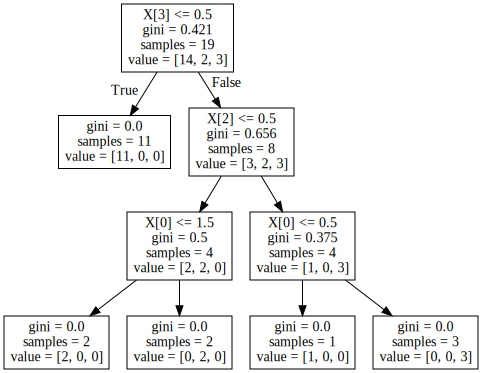

In [87]:
#绘制树形图
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain1, Ytrain1)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(dot_data)


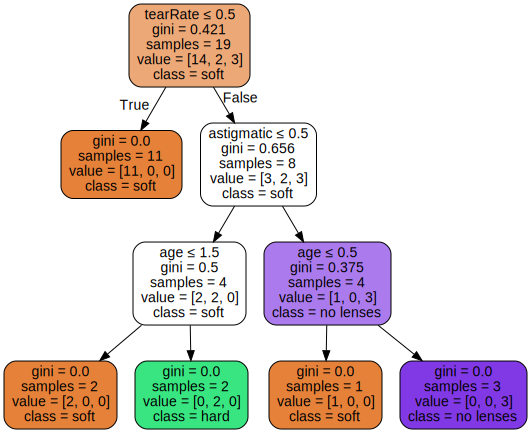

In [88]:
#添加标签和颜色
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=['age', 'prescript', 'astigmatic','tearRate'],
                                class_names=['soft','hard','no lenses'],
                                filled=True, rounded=True,special_characters=True)
graphviz.Source(dot_data)

In [89]:
#使用render存储树形图
graph = graphviz.Source(dot_data)
graph.render("lense")

'lense.pdf'